In [27]:
# Imports
import glob
import numpy as np
import imageio
import os.path as path
from scipy import misc

In [28]:
IMAGE_PATH = 'planesnet/planesnet'
file_paths = glob.glob(path.join(IMAGE_PATH, '*.png'))

In [29]:
# Load the images
images = [imageio.imread(path) for path in file_paths]
images = np.asarray(images)

In [30]:
# Scale
images = images / 255

In [31]:
# Read the labels from the filenames
n_images = images.shape[0]
labels = np.zeros(n_images)
for i in range(n_images):
    filename = path.basename(file_paths[i])[0]
    labels[i] = int(filename[0])

In [32]:
# Split into test and training sets
TRAIN_TEST_SPLIT = 0.8

# Split at the given index
split_index = int(TRAIN_TEST_SPLIT * n_images)
shuffled_indices = np.random.permutation(n_images)
train_indices = shuffled_indices[0:split_index]
test_indices = shuffled_indices[split_index:]

# Split the images and the labels
x_train = images[train_indices, :, :, :]
y_train = labels[train_indices]
x_test = images[test_indices, :, :, :]
y_test = labels[test_indices]

In [33]:
import matplotlib.pyplot as plt

In [34]:
def visualize_data(positive_images, negative_images):

    figure = plt.figure()
    count = 0
    for i in range(positive_images.shape[0]):
        count += 1
        figure.add_subplot(2, positive_images.shape[0], count)
        plt.imshow(positive_images[i, :, :])
        plt.axis('off')
        plt.title("1")

        figure.add_subplot(1, negative_images.shape[0], count)
        plt.imshow(negative_images[i, :, :])
        plt.axis('off')
        plt.title("0")
    plt.show()

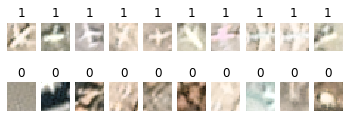

In [35]:
# Number of positive and negative examples to show
N_TO_VISUALIZE = 10

positive_example_indices = (y_train == 1)
positive_examples = x_train[positive_example_indices, :, :]
positive_examples = positive_examples[0:N_TO_VISUALIZE, :, :]

negative_example_indices = (y_train == 0)
negative_examples = x_train[negative_example_indices, :, :]
negative_examples = negative_examples[0:N_TO_VISUALIZE, :, :]

visualize_data(positive_examples, negative_examples)

In [36]:
# Imports
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import accuracy_score, f1_score
from datetime import datetime

In [37]:
# Hyperparamater
N_LAYERS = 4

In [38]:
def cnn(size, n_layers):

    MIN_NEURONS = 20
    MAX_NEURONS = 120
    KERNEL = (3, 3)

    # Determine the # of neurons in each convolutional layer
    steps = np.floor(MAX_NEURONS / (n_layers + 1))
    nuerons = np.arange(MIN_NEURONS, MAX_NEURONS, steps)
    nuerons = nuerons.astype(np.int32)

    model = Sequential()

    for i in range(0, n_layers):
        if i == 0:
            shape = (size[0], size[1], size[2])
            model.add(Conv2D(nuerons[i], KERNEL, input_shape=shape))
        else:
            model.add(Conv2D(nuerons[i], KERNEL))

        model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(MAX_NEURONS))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.summary()

    return model

In [39]:
# Instantiate the model
image_size=images[0].shape
print(image_size)
model = cnn(image_size,N_LAYERS)

(20, 20, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 18, 18, 20)        560       
_________________________________________________________________
activation_7 (Activation)    (None, 18, 18, 20)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 44)        7964      
_________________________________________________________________
activation_8 (Activation)    (None, 16, 16, 44)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 68)        26996     
_________________________________________________________________
activation_9 (Activation)    (None, 14, 14, 68)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 92)        56396    

In [40]:
EPOCHS = 150
BATCH_SIZE = 200

In [41]:
PATIENCE = 10
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=PATIENCE, verbose=1, mode='auto')

In [42]:
LOG_DIRECTORY_ROOT = ''
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
log_dir = "{}/run-{}/".format(LOG_DIRECTORY_ROOT, now)
tensorboard = TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)

In [43]:
callbacks = [early_stopping, tensorboard]

In [44]:
# Train the model
history=model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=1)



Epoch 1/150
25600/25600 [==============================] - 65s 3ms/step - loss: 0.3741 - acc: 0.8306
Epoch 2/150
25600/25600 [==============================] - 63s 2ms/step - loss: 0.1944 - acc: 0.9225
Epoch 3/150
25600/25600 [==============================] - 63s 2ms/step - loss: 0.1482 - acc: 0.9410
Epoch 4/150
25600/25600 [==============================] - 63s 2ms/step - loss: 0.1188 - acc: 0.9544
Epoch 5/150
25600/25600 [==============================] - 64s 2ms/step - loss: 0.1020 - acc: 0.9609
Epoch 6/150
25600/25600 [==============================] - 64s 2ms/step - loss: 0.0959 - acc: 0.9647
Epoch 7/150
25600/25600 [==============================] - 64s 2ms/step - loss: 0.0891 - acc: 0.9675
Epoch 8/150
25600/25600 [==============================] - 64s 2ms/step - loss: 0.0805 - acc: 0.9702
Epoch 9/150
25600/25600 [==============================] - 67s 3ms/step - loss: 0.0709 - acc: 0.9743
Epoch 10/150
25600/25600 [==============================] - 65s 3ms/step - loss: 0.0639 -

In [61]:
# Make a prediction on the test set
import tensorflow as tf
graph = tf.get_default_graph()

with graph.as_default():
    test_predictions = model.predict(x_test)
    test_predictions = np.round(test_predictions)
print(test_predictions.size)

6400


In [62]:
# Report the accuracy
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: " + str(accuracy))

Accuracy: 0.985


In [47]:
model.save("BTPCNN_Save.h5")
model.save_weights("BTPCNN_Saveweight.h5")

In [48]:
from keras.models import load_model
model=load_model('BTPCNN_Save.h5')

In [49]:
print(history.history.keys())

dict_keys(['loss', 'acc'])


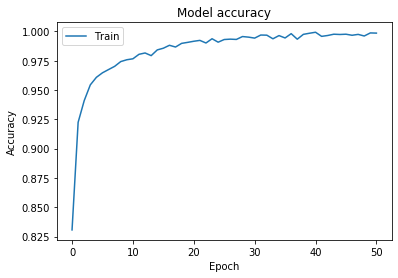

In [50]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

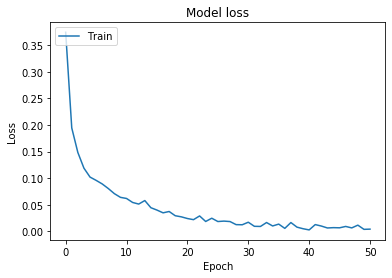

In [51]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

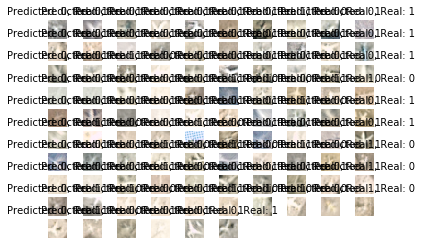

In [52]:
def visualize_incorrect_labels(x_data, y_real, y_predicted):
    # INPUTS
    # x_data      - images
    # y_data      - ground truth labels
    # y_predicted - predicted label
    count = 0
    figure = plt.figure()
    incorrect_label_indices = (y_real != y_predicted)
    y_real = y_real[incorrect_label_indices]
    y_predicted = y_predicted[incorrect_label_indices]
    x_data = x_data[incorrect_label_indices, :, :, :]

    maximum_square = np.ceil(np.sqrt(x_data.shape[0]))

    for i in range(x_data.shape[0]):
        count += 1
        figure.add_subplot(maximum_square, maximum_square, count)
        plt.imshow(x_data[i, :, :, :])
        plt.axis('off')
        plt.title("Predicted: " + str(int(y_predicted[i])) + ", Real: " + str(int(y_real[i])), fontsize=10)

    plt.show()

visualize_incorrect_labels(x_test, y_test, np.asarray(test_predictions).ravel())

In [65]:

import anvil.server

anvil.server.connect("VBANUMCCVRMR67RZTN3L6E6L-5KZRRTKPDBQKOB7J")

Anvil websocket closed (code 1006, reason=Going away)
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink


Exception in thread Thread-7:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\anvil\server.py", line 286, in call
    return _do_call(args, kwargs, fn_name=fn_name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\anvil\server.py", line 278, in _do_call
    return _threaded_server.do_call(args, kwargs, fn_name=fn_name, live_object=live_object)
  File "C:\ProgramData\Anaconda3\lib\site-packages\anvil\_threaded_server.py", line 357, in do_call
    raise _server._deserialise_exception(r["error"])
anvil._server.AnvilWrappedError: 'Connection to Anvil Uplink server lost'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 917, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\anvil\server.py", l

Anvil websocket open
Authenticated OK
Anvil websocket closed (code 1006, reason=Going away)


Exception in thread Thread-36:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\anvil\server.py", line 286, in call
    return _do_call(args, kwargs, fn_name=fn_name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\anvil\server.py", line 278, in _do_call
    return _threaded_server.do_call(args, kwargs, fn_name=fn_name, live_object=live_object)
  File "C:\ProgramData\Anaconda3\lib\site-packages\anvil\_threaded_server.py", line 357, in do_call
    raise _server._deserialise_exception(r["error"])
anvil._server.AnvilWrappedError: 'Connection to Anvil Uplink server lost'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 917, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\anvil\server.py", 

Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Authenticated OK
Anvil websocket closed (code 1006, reason=Going away)


Exception in thread Thread-52:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\anvil\server.py", line 286, in call
    return _do_call(args, kwargs, fn_name=fn_name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\anvil\server.py", line 278, in _do_call
    return _threaded_server.do_call(args, kwargs, fn_name=fn_name, live_object=live_object)
  File "C:\ProgramData\Anaconda3\lib\site-packages\anvil\_threaded_server.py", line 357, in do_call
    raise _server._deserialise_exception(r["error"])
anvil._server.AnvilWrappedError: 'Connection to Anvil Uplink server lost'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 917, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\anvil\server.py", 

Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Authenticated OK
Anvil websocket closed (code 1006, reason=Going away)
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting 10 seconds, then retrying.
Reconnecting Anvil Uplink...
Connecting to wss://anvil.works/uplink
Reconnection failed. Waiting

In [59]:
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import PIL 

In [63]:
import tensorflow as tf
graph = tf.get_default_graph()

In [64]:
import anvil.media

@anvil.server.callable
def classify_image(file):
    with anvil.media.TempFile(file) as filename:
        img = load_img(filename)
        
    img = img.resize((20,20), resample=PIL.Image.BICUBIC)
    arr = np.asarray(img)
    arr = np.expand_dims(arr, axis=0)
    arr = arr / 255
    with graph.as_default():
        score = model.predict(arr)
    score = np.round(score)
    if(score==0):
        result = "Aircraft is not present"
    else:
        result = "Aircraft is present"
    
    return result, score